# 네이버 영화리뷰 텍스트 감성분석


3가지 이상의 모델이 성공적으로 시도됨

gensim의 유사단어 찾기를 활용하여 자체학습한 
임베딩과 사전학습 임베딩을 적절히 분석함

네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성  

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter] #단어장 패딩용,문장시작,사전에없는,사용하지않는
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [6]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
#word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[4])     
print(word_to_index['the'])
# print(word_to_index)

.
1909


In [8]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [9]:
#전체 데이터셋의 분포를 확인
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장 길이 평균: ', np.mean(num_tokens))
print('문장 길이 최대: ', np.max(num_tokens))
print('문장 길이 표준편차: ', np.std(num_tokens))

# 예시로, 최대 길이를 *(평균 + 2 * 표준편차)로 설정할 경우
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장 길이 평균:  15.96940191154864
문장 길이 최대:  116
문장 길이 표준편차:  12.843571191092
pad_sequences maxlen:  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함된다.


In [10]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


## 4) 모델 구성 및 validation set 구성

#### 3가지 이상

In [11]:
vocab_size = len(index_to_word)  # 어휘 사전의 크기입니다(
word_vector_dim = 300
# 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 


## 4) 1. RNN

Recurrent Neural Network(RNN)입니다. RNN은 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델로 알려져 있습니다.
RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었있습니다.

In [12]:
# RNN

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


## 4) 2. CNN

1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝(합성곱의방향 가로 한방향 출력벡터) 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됩니다. 이 방식도 텍스트를 처리하는 데 RNN 못지않은 효율을 보여줍니다.
그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점이 있습니다.

In [13]:
# CNN 

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(128, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         268928    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          28704     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## 4) 3. GlobalMaxPooling1D

레이어 하나만 사용하는 방법
이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있습니다.

In [14]:
# GlobalMaxPooling1D as GMP

GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [15]:
# validation set 20000 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### 5) 모델 훈련 개시


In [16]:
RNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

RNN_history = RNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 5s 9ms/step - loss: 0.4363 - accuracy: 0.8069 - val_loss: 0.3466 - val_accuracy: 0.8504
Epoch 2/10
247/247 [==============================] - 2s 7ms/step - loss: 0.3180 - accuracy: 0.8659 - val_loss: 0.3358 - val_accuracy: 0.8566
Epoch 3/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2859 - accuracy: 0.8801 - val_loss: 0.3420 - val_accuracy: 0.8548
Epoch 4/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2578 - accuracy: 0.8930 - val_loss: 0.3460 - val_accuracy: 0.8564
Epoch 5/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2311 - accuracy: 0.9047 - val_loss: 0.3569 - val_accuracy: 0.8582
Epoch 6/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2076 - accuracy: 0.9153 - val_loss: 0.3788 - val_accuracy: 0.8545
Epoch 7/10
247/247 [==============================] - 2s 7ms/step - loss: 0.1866 - accuracy: 0.9258 - val_loss: 0.4001 - val_accuracy: 0.8553
Epoch 

In [17]:
# 모델 간단평가
results = RNN_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4951 - accuracy: 0.8438
[0.4950874149799347, 0.8438472747802734]


In [18]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_history = cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 6s 18ms/step - loss: 0.4022 - accuracy: 0.8118 - val_loss: 0.3266 - val_accuracy: 0.8579
Epoch 2/10
247/247 [==============================] - 4s 14ms/step - loss: 0.2736 - accuracy: 0.8877 - val_loss: 0.3149 - val_accuracy: 0.8645
Epoch 3/10
247/247 [==============================] - 4s 14ms/step - loss: 0.1879 - accuracy: 0.9286 - val_loss: 0.3568 - val_accuracy: 0.8587
Epoch 4/10
247/247 [==============================] - 4s 14ms/step - loss: 0.1032 - accuracy: 0.9650 - val_loss: 0.4440 - val_accuracy: 0.8492
Epoch 5/10
247/247 [==============================] - 4s 14ms/step - loss: 0.0586 - accuracy: 0.9810 - val_loss: 0.5411 - val_accuracy: 0.8502
Epoch 6/10
247/247 [==============================] - 4s 15ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.6564 - val_accuracy: 0.8447
Epoch 7/10
247/247 [==============================] - 4s 15ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.7354 - val_accuracy: 0.8487

In [19]:
# 모델 간단평가
results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8556 - accuracy: 0.8430
[0.8555653691291809, 0.8430132269859314]


In [20]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 6ms/step - loss: 0.4521 - accuracy: 0.8142 - val_loss: 0.3420 - val_accuracy: 0.8510
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3074 - accuracy: 0.8709 - val_loss: 0.3329 - val_accuracy: 0.8537
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2599 - accuracy: 0.8948 - val_loss: 0.3384 - val_accuracy: 0.8562
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2163 - accuracy: 0.9159 - val_loss: 0.3554 - val_accuracy: 0.8546
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 0.1712 - accuracy: 0.9387 - val_loss: 0.3794 - val_accuracy: 0.8530
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.1250 - accuracy: 0.9590 - val_loss: 0.4201 - val_accuracy: 0.8482
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.0844 - accuracy: 0.9761 - val_loss: 0.4652 - val_accuracy: 0.8472
Epoch 

In [21]:
# 모델 간단평가
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6066 - accuracy: 0.8398
[0.6065943837165833, 0.8397989869117737]


### 6) Loss, Accuracy 그래프 시각화

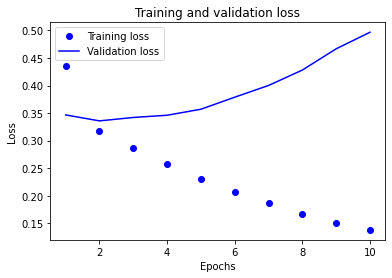

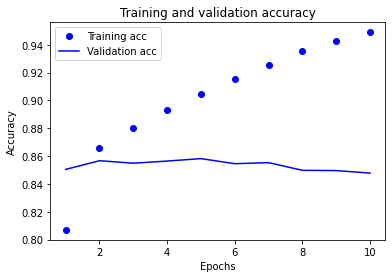

In [22]:
import matplotlib.pyplot as plt
history_dict = RNN_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

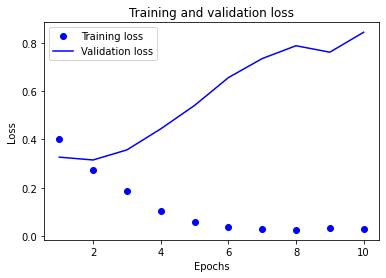

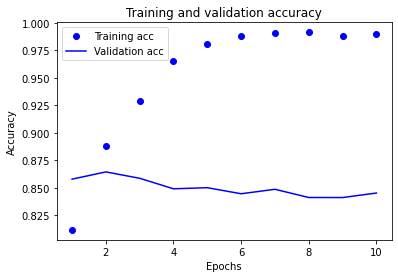

In [23]:
history_dict = cnn_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

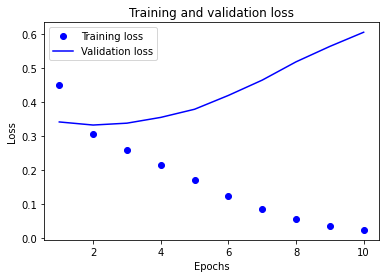

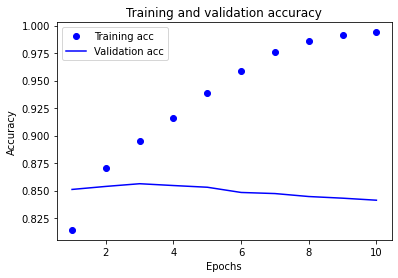

In [24]:
history_dict = GMP_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [25]:
embedding_layer = RNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [26]:
# 학습한 embedding 파라미터를 파일로 저장
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 어떤 사이즈로 기재할지의 타이틀.

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = RNN_model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
# gensim에서 제공하는 패키지로, 위에서 만든 임베딩 파라미터를 익어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-7.47767016e-02, -1.26235280e-02, -2.12028958e-02,  7.48538645e-03,
       -3.11232340e-02, -5.43108284e-02,  8.22034627e-02,  3.27311940e-02,
        8.56801197e-02, -1.54869277e-02, -3.45802195e-02,  8.84980953e-04,
        5.78057803e-02, -2.13486087e-02,  5.82787432e-02,  6.82951882e-02,
        6.52162507e-02, -4.35716324e-02,  5.83100040e-03,  2.46755704e-02,
       -1.11608826e-01,  1.01333648e-01, -7.60751888e-02,  7.84834251e-02,
        7.44672120e-02,  9.45320949e-02, -6.49327934e-02, -1.54065797e-02,
       -3.84466499e-02,  1.67249545e-01,  7.27833947e-03, -7.17298165e-02,
       -5.34985438e-02, -4.30368297e-02, -8.28141719e-02, -1.10244468e-01,
       -9.61298943e-02,  1.26557034e-02,  4.54122992e-03, -2.26784125e-02,
        3.34116146e-02,  7.74361342e-02, -2.14801311e-01, -4.21658345e-02,
        1.54013904e-02, -1.06829423e-02, -1.29015476e-01,  4.73857746e-02,
       -9.90442038e-02, -1.60101894e-02, -1.33114606e-01, -4.89721224e-02,
        1.94032360e-02, -

In [28]:
word_vectors.similar_by_word("컴퓨터") #유사단어 찾기

[('헬', 0.7838122844696045),
 ('뻥튀기', 0.7602183818817139),
 ('끝냈', 0.7472996115684509),
 ('변해', 0.7422032952308655),
 ('ocn', 0.7392600774765015),
 ('범죄자', 0.7351723909378052),
 ('하나같이', 0.7339091300964355),
 ('케릭', 0.7309196591377258),
 ('메르스', 0.726854145526886),
 ('경치', 0.7239492535591125)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [29]:
# Google의 Word2Vec 모델을 가져와 적용
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.


array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

300dim의 벡터로 이루어진 300만 개의 단어입니다. 이 단어 사전을 메모리에 모두 로딩하면 아주 높은 확률로 여러분의 실습환경에 메모리 에러가 날 것입니다.  
그래서 KeyedVectors.load_word2vec_format 메서드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩했습니다.

메모리가 충분하다면 limt=None으로 하시면 300만 개를 모두 로딩합니다.

In [30]:
word2vec.similar_by_word("love") #의미적 유사도가 비슷한 것

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있습니다. 이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [36]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성 RNN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 3,572,433
Trainable params: 3,572,433
Non-trainable params: 0
_________________________________________________________________


In [37]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 9s 32ms/step - loss: 0.5100 - accuracy: 0.7346 - val_loss: 0.4303 - val_accuracy: 0.8019
Epoch 2/10
247/247 [==============================] - 8s 31ms/step - loss: 0.3534 - accuracy: 0.8478 - val_loss: 0.3682 - val_accuracy: 0.8395
Epoch 3/10
247/247 [==============================] - 8s 31ms/step - loss: 0.3213 - accuracy: 0.8634 - val_loss: 0.3397 - val_accuracy: 0.8537
Epoch 4/10
247/247 [==============================] - 8s 32ms/step - loss: 0.3006 - accuracy: 0.8739 - val_loss: 0.3350 - val_accuracy: 0.8576
Epoch 5/10
247/247 [==============================] - 8s 32ms/step - loss: 0.2816 - accuracy: 0.8829 - val_loss: 0.3338 - val_accuracy: 0.8573
Epoch 6/10
247/247 [==============================] - 8s 32ms/step - loss: 0.2650 - accuracy: 0.8911 - val_loss: 0.3286 - val_accuracy: 0.8590
Epoch 7/10
247/247 [==============================] - 8s 32ms/step - loss: 0.2513 - accuracy: 0.8977 - val_loss: 0.3747 - val_accuracy: 0.8425

In [34]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4450 - accuracy: 0.8340
[0.4449600875377655, 0.8340216279029846]


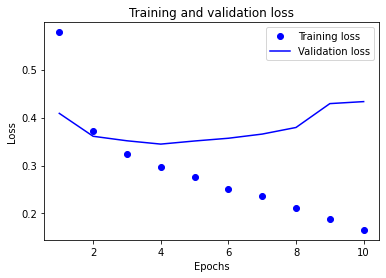

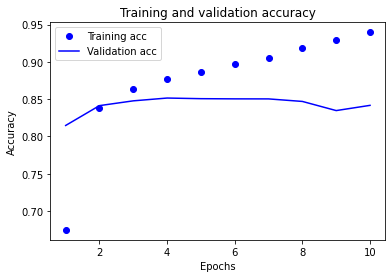

In [35]:
#모델의 결과값을 그래프로 표시
history = history.history
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고

RNN,GMP,CNN 순으로 값이 좋게나왔다  
그래서 좋은 RNN모델로 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델을 가져다 활용해 확인해보니 loss: 0.4951 - accuracy: 0.8438 -> loss: 0.4450 - accuracy: 0.8340  
성능이 조금 더 좋아진것을 확인할 수 있었다.   
성능을 더 올리고 싶어 모델 구성안의 하이퍼파라미터를 바꾸다 오히려 더 떨어지는 것을 보아 아직 모델 구성들을 제대로 이해하지 못한 거 같기에 추후 복습이 꼭 필요할 거 같다.